# Solving the Permuted Sequential MNIST (psMNIST) Task

The psMNIST (Permuted Sequential MNIST) task is a image classification task introduced in 2015 by Le, Jaitly, and Hinton ([see paper](https://arxiv.org/pdf/1504.00941.pdf)). It is based on the Sequential MNIST task, which itself is a derivative of the MNIST task. Like the MNIST task, the goal of the psMNIST task is to have a neural network process a 28 x 28 pixel image (of a handwritten digit) into one of ten digits (0 to 9).

However, while the MNIST task presents the entire image to the network all at once, the Sequential MNIST and psMNIST tasks turn the image into a stream of 784 (28x28) individual pixels, presented to the network one at a time. The goal of the network is then to classify the pixel sequence as the appropriate digit after the last pixel has been shown. The psMNIST task adds more complexity to the input by applying a fixed permutation to all of the pixel sequences. This is done to ensure that the information contained in the image is distributed evenly throughout the sequence, so that in order to perform the task successfully, the network needs to process information across the whole length of the input sequence.

The following notebook uses a single NengoLMU layer inside a simple TensorFlow model to showcase the accuracy and efficiency of performing the psMNIST task using these novel memory cells. Using the LMU for this task currently produces state-of-the-art results this task ([see paper](https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks.pdf)).

In [1]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf

from lmu import LMU

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

## Step 1: Loading and Formatting the Dataset

First we set a seed to ensure that the results in this example are reproducible. A random number generator state (`rng`) is also created, and this will later be used to generate the fixed permutation to be applied to the image data.

In [2]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

We now obtain the standard MNIST dataset of handwritten digits from `tf.keras.datasets`.

In [3]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data())

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

 8781824/11490434 [=====================>........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


Since the pixel values of each image in the dataset have a range of 0 to 255, they are divided by 255 to change this range to 0 to 1. Let's also display a sample image from the MNIST dataset to get an idea of the kind of images the network is working with.

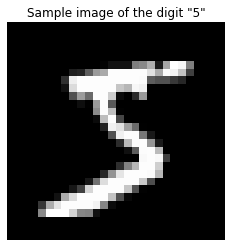

In [4]:
train_images = train_images / 255
test_images = test_images / 255

plt.figure()
plt.imshow(np.reshape(train_images[0], (28, 28)), cmap="gray")
plt.axis("off")
plt.title('Sample image of the digit "%d"' % (train_labels[0]));

Next, we have to convert the data from the MNIST format into the sequence of pixels that is used in the psMNIST task. To do this, we flatten the image by calling the `reshape` method on the images. The first dimension of the reshaped output size represents the number of samples our dataset has, which we keep the same. We want to transform each sample into a column vector, and to do so we make the second and third dimensions -1 and 1, respectively, leveraging a standard NumPy trick specifically used for converting multi-dimensional data into column vectors.

The image displayed below shows the result of this flattening process, and is an example of the type of data that is used in the Sequential MNIST task. Note that even though the image has been reshaped into an 98 x 8 image (so that it can fit on the screen), there is still a fair amount of structure observable in the image.

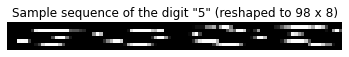

In [5]:
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# we'll display the sequence in 8 rows just so that it fits better on the screen
plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title('Sample sequence of the digit "%d" (reshaped to 98 x 8)' % (train_labels[0]));

Finally, we apply a fixed permutation on the images in both the training and testing datasets. This essentially shuffles the pixels of the image sequences in a consistent way, allowing for images of the same digit to still be similar, but removing the convenience of edges and contours that the network can use for easy digit inference.

We can see, from the image below, that the fixed permutation applied to the image creates an even distribute of pixels across the entire sequence. This makes the task much more difficult as it makes it necessary for the network to process the entire input sequence to accurately predict what the digit is. We now have our data for the Permuted Sequential MNIST (psMNIST) task.

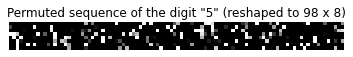

In [6]:
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(
    'Permuted sequence of the digit "%d" (reshaped to 98 x 8)' % (train_labels[0])
);

From the images in the training set, we allocate the first 50,000 images for training, and the remaining 10,000 for validation. We print out the shapes of these datasets to ensure the slicing has been done correctly.

In [7]:
X_train = train_images[0:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[0:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(
    "Training inputs shape: %s, Training targets shape: %s"
    % (str(X_train.shape), str(Y_train.shape))
)
print(
    "Validation inputs shape: %s, Validation targets shape: %s"
    % (str(X_valid.shape), str(Y_valid.shape))
)
print(
    "Testing inputs shape: %s, Testing targets shape: %s"
    % (str(X_test.shape), str(Y_test.shape))
)

Training inputs shape: (50000, 784, 1), Training targets shape: (50000,)
Validation inputs shape: (10000, 784, 1), Validation targets shape: (10000,)
Testing inputs shape: (10000, 784, 1), Testing targets shape: (10000,)


## Step 2: Defining the Model

Our model uses a single LMU layer configured with 212 `units` and an `order` of 256 dimensions for the memory, maintaining `units` + `order` = 468 variables in memory between time-steps. These numbers were chosen primarily to have a comparable number of internal variables to the models that were being compared against in the [paper](https://arxiv.org/pdf/1504.00941.pdf).

The hidden state is projected to an output softmax layer. We set `theta` to 784 (the number of pixels in each sequence), and initialize the hidden and memory encoders, and input and hidden kernels to 0, in order to test the ability of the network to learn these parameters.

The output of the LMU layer is connected to a `Dense` layer with an output dimensionality of 10, one for each possible digit class.

In [8]:
n_pixels = X_train.shape[1:][0]

lmu_layer = LMU(
    units=212,
    order=256,
    theta=n_pixels,
    input_encoders_initializer=Constant(1),
    hidden_encoders_initializer=Constant(0),
    memory_encoders_initializer=Constant(0),
    input_kernel_initializer=Constant(0),
    hidden_kernel_initializer=Constant(0),
    memory_kernel_initializer="glorot_normal",
    return_sequences=False,
)

# TensorFlow layer definition
inputs = Input(X_train.shape[1:])  # shape = (number of pixels, 1)
lmus = lmu_layer(inputs)
outputs = Dense(10, activation="softmax")(lmus)  # Number of output classes (10)

# TensorFlow model definition
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784, 1)]          0         
_________________________________________________________________
lmu (LMU)                    (None, 212)               165689    
_________________________________________________________________
dense (Dense)                (None, 10)                2130      
Total params: 167,819
Trainable params: 102,027
Non-trainable params: 65,792
_________________________________________________________________


## Step 3: Training the Model

To train our model, we use a `batch_size` of 100, and train for 5 `epochs`, which is a far less than most other solutions to the psMNIST task. We could train for more epochs if we wished to fine-tune performance, but that is not necessary for the purposes of this example. We also create a `ModelCheckpoint` callback that saves the weights of the model to a file after each epoch.

The time required for this to run is tracked using the `time` library. Training may take a long time to complete, and to save time, this notebook defaults to using pre-trained weights. To train the model from scratch, simply change the `do_training` variable to `True` before running the cell below.

In [9]:
do_training = False
batch_size = 100
epochs = 5
t = time.time()

saved_weights_fname = "./psMNIST-weights.hdf5"
callbacks = [
    ModelCheckpoint(
        filepath=saved_weights_fname, monitor="val_loss", verbose=1, save_best_only=True
    ),
]

if do_training:
    result = model.fit(
        X_train,
        to_categorical(Y_train),
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, to_categorical(Y_valid)),
        callbacks=callbacks,
    )

    print("Total training time: {:.2f} mins".format((time.time() - t) / 60))

## Step 4: Plotting Learning

The progression of the training process is shown below. Here we plot the accuracy for the training and validation for each of the 5 epochs.

Note that if this notebook has been configured to use trained weights, instead of using live data, a saved image of a previous training run will be displayed.

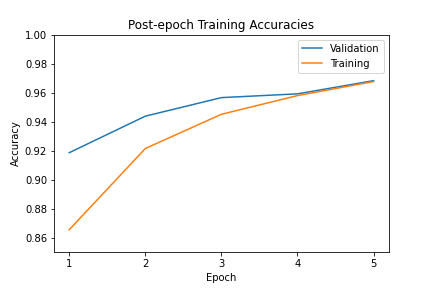

In [10]:
if do_training:
    plt.figure()
    plt.plot(result.history["val_accuracy"], label="Validation")
    plt.plot(result.history["accuracy"], label="Training")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Post-epoch Training Accuracies")
    plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
    plt.ylim((0.85, 1.0))  # Restrict range of y axis to (0.85, 1) for readability
    plt.savefig("psMNIST-training.png")

    val_loss_min = np.argmin(result.history["val_loss"])
    print(
        "Maximum validation accuracy: %0.2f%%"
        % round(result.history["val_accuracy"][val_loss_min] * 100, 2)
    )

else:
    display(Image(filename="psMNIST-training.png"))

## Step 5: Testing the Model

With the training complete, let's use the trained weights to test the model. Since the weights are saved to file after every epoch, we can simply load the saved weights, then test it against the permuted sequences in the test set.

In [11]:
model.load_weights(saved_weights_fname)
accuracy = model.evaluate(X_test, to_categorical(Y_test))[1] * 100
print("Test accuracy: %0.2f%%" % round(accuracy, 2))

  1/313 [..............................] - ETA: 0s - loss: 0.1789 - accuracy: 0.9688

  2/313 [..............................] - ETA: 38s - loss: 0.1048 - accuracy: 0.9844

  3/313 [..............................] - ETA: 52s - loss: 0.0765 - accuracy: 0.9896

  4/313 [..............................] - ETA: 58s - loss: 0.0684 - accuracy: 0.9922

  5/313 [..............................] - ETA: 1:01 - loss: 0.0653 - accuracy: 0.9875

  6/313 [..............................] - ETA: 1:03 - loss: 0.0567 - accuracy: 0.9896

  7/313 [..............................] - ETA: 1:05 - loss: 0.0507 - accuracy: 0.9911

  8/313 [..............................] - ETA: 1:06 - loss: 0.0583 - accuracy: 0.9844

  9/313 [..............................] - ETA: 1:07 - loss: 0.0601 - accuracy: 0.9826

 10/313 [..............................] - ETA: 1:07 - loss: 0.0590 - accuracy: 0.9844

 11/313 [>.............................] - ETA: 1:08 - loss: 0.0688 - accuracy: 0.9773

 12/313 [>.............................] - ETA: 1:08 - loss: 0.0810 - accuracy: 0.9766

 13/313 [>.............................] - ETA: 1:08 - loss: 0.0800 - accuracy: 0.9760

 14/313 [>.............................] - ETA: 1:08 - loss: 0.0869 - accuracy: 0.9710

 15/313 [>.............................] - ETA: 1:08 - loss: 0.0904 - accuracy: 0.9708

 16/313 [>.............................] - ETA: 1:08 - loss: 0.0970 - accuracy: 0.9688

 17/313 [>.............................] - ETA: 1:08 - loss: 0.0950 - accuracy: 0.9688

 18/313 [>.............................] - ETA: 1:08 - loss: 0.0970 - accuracy: 0.9688

 19/313 [>.............................] - ETA: 1:08 - loss: 0.0974 - accuracy: 0.9671

 20/313 [>.............................] - ETA: 1:08 - loss: 0.1022 - accuracy: 0.9625

 21/313 [=>............................] - ETA: 1:08 - loss: 0.1016 - accuracy: 0.9628

 22/313 [=>............................] - ETA: 1:08 - loss: 0.1029 - accuracy: 0.9616

 23/313 [=>............................] - ETA: 1:08 - loss: 0.1072 - accuracy: 0.9606

 24/313 [=>............................] - ETA: 1:08 - loss: 0.1047 - accuracy: 0.9609

 25/313 [=>............................] - ETA: 1:08 - loss: 0.1057 - accuracy: 0.9600

 26/313 [=>............................] - ETA: 1:08 - loss: 0.1021 - accuracy: 0.9615

 27/313 [=>............................] - ETA: 1:07 - loss: 0.1011 - accuracy: 0.9618

 28/313 [=>............................] - ETA: 1:07 - loss: 0.1044 - accuracy: 0.9609

 29/313 [=>............................] - ETA: 1:07 - loss: 0.1046 - accuracy: 0.9612

 30/313 [=>............................] - ETA: 1:07 - loss: 0.1119 - accuracy: 0.9573

 31/313 [=>............................] - ETA: 1:07 - loss: 0.1108 - accuracy: 0.9567

 32/313 [==>...........................] - ETA: 1:07 - loss: 0.1150 - accuracy: 0.9561

 33/313 [==>...........................] - ETA: 1:06 - loss: 0.1157 - accuracy: 0.9555

 34/313 [==>...........................] - ETA: 1:06 - loss: 0.1153 - accuracy: 0.9559

 35/313 [==>...........................] - ETA: 1:06 - loss: 0.1187 - accuracy: 0.9536

 36/313 [==>...........................] - ETA: 1:06 - loss: 0.1210 - accuracy: 0.9531

 37/313 [==>...........................] - ETA: 1:06 - loss: 0.1227 - accuracy: 0.9535

 38/313 [==>...........................] - ETA: 1:05 - loss: 0.1225 - accuracy: 0.9539

 39/313 [==>...........................] - ETA: 1:05 - loss: 0.1346 - accuracy: 0.9519

 40/313 [==>...........................] - ETA: 1:05 - loss: 0.1391 - accuracy: 0.9508

 41/313 [==>...........................] - ETA: 1:05 - loss: 0.1445 - accuracy: 0.9497

 42/313 [===>..........................] - ETA: 1:05 - loss: 0.1488 - accuracy: 0.9479

 43/313 [===>..........................] - ETA: 1:05 - loss: 0.1461 - accuracy: 0.9491

 44/313 [===>..........................] - ETA: 1:05 - loss: 0.1478 - accuracy: 0.9482

 45/313 [===>..........................] - ETA: 1:05 - loss: 0.1466 - accuracy: 0.9486

 46/313 [===>..........................] - ETA: 1:04 - loss: 0.1460 - accuracy: 0.9477

 47/313 [===>..........................] - ETA: 1:04 - loss: 0.1477 - accuracy: 0.9475

 48/313 [===>..........................] - ETA: 1:04 - loss: 0.1505 - accuracy: 0.9473

 49/313 [===>..........................] - ETA: 1:04 - loss: 0.1507 - accuracy: 0.9471

 50/313 [===>..........................] - ETA: 1:03 - loss: 0.1498 - accuracy: 0.9475

 51/313 [===>..........................] - ETA: 1:03 - loss: 0.1536 - accuracy: 0.9467

 52/313 [===>..........................] - ETA: 1:03 - loss: 0.1517 - accuracy: 0.9471

 53/313 [====>.........................] - ETA: 1:03 - loss: 0.1547 - accuracy: 0.9469

 54/313 [====>.........................] - ETA: 1:02 - loss: 0.1557 - accuracy: 0.9468

 55/313 [====>.........................] - ETA: 1:02 - loss: 0.1600 - accuracy: 0.9460

 56/313 [====>.........................] - ETA: 1:02 - loss: 0.1616 - accuracy: 0.9464

 57/313 [====>.........................] - ETA: 1:02 - loss: 0.1593 - accuracy: 0.9474

 58/313 [====>.........................] - ETA: 1:01 - loss: 0.1572 - accuracy: 0.9483

 59/313 [====>.........................] - ETA: 1:01 - loss: 0.1561 - accuracy: 0.9486

 60/313 [====>.........................] - ETA: 1:01 - loss: 0.1569 - accuracy: 0.9484

 61/313 [====>.........................] - ETA: 1:01 - loss: 0.1576 - accuracy: 0.9483

 62/313 [====>.........................] - ETA: 1:01 - loss: 0.1570 - accuracy: 0.9481

 63/313 [=====>........................] - ETA: 1:00 - loss: 0.1571 - accuracy: 0.9479

 64/313 [=====>........................] - ETA: 1:00 - loss: 0.1622 - accuracy: 0.9458

 65/313 [=====>........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9457

 66/313 [=====>........................] - ETA: 1:00 - loss: 0.1654 - accuracy: 0.9455

 67/313 [=====>........................] - ETA: 59s - loss: 0.1740 - accuracy: 0.9440 

 68/313 [=====>........................] - ETA: 59s - loss: 0.1726 - accuracy: 0.9444

 69/313 [=====>........................] - ETA: 59s - loss: 0.1720 - accuracy: 0.9443

 70/313 [=====>........................] - ETA: 59s - loss: 0.1705 - accuracy: 0.9446

 71/313 [=====>........................] - ETA: 58s - loss: 0.1687 - accuracy: 0.9450

 72/313 [=====>........................] - ETA: 58s - loss: 0.1703 - accuracy: 0.9449

 73/313 [=====>........................] - ETA: 58s - loss: 0.1697 - accuracy: 0.9448

 74/313 [======>.......................] - ETA: 58s - loss: 0.1682 - accuracy: 0.9451

 75/313 [======>.......................] - ETA: 58s - loss: 0.1696 - accuracy: 0.9446

 76/313 [======>.......................] - ETA: 57s - loss: 0.1703 - accuracy: 0.9437

 77/313 [======>.......................] - ETA: 57s - loss: 0.1694 - accuracy: 0.9440

 78/313 [======>.......................] - ETA: 57s - loss: 0.1685 - accuracy: 0.9443

 79/313 [======>.......................] - ETA: 57s - loss: 0.1668 - accuracy: 0.9450

 80/313 [======>.......................] - ETA: 56s - loss: 0.1653 - accuracy: 0.9457

 81/313 [======>.......................] - ETA: 56s - loss: 0.1647 - accuracy: 0.9460

 82/313 [======>.......................] - ETA: 56s - loss: 0.1683 - accuracy: 0.9455

 83/313 [======>.......................] - ETA: 56s - loss: 0.1703 - accuracy: 0.9454

 84/313 [=======>......................] - ETA: 55s - loss: 0.1690 - accuracy: 0.9461

 85/313 [=======>......................] - ETA: 55s - loss: 0.1677 - accuracy: 0.9463

 86/313 [=======>......................] - ETA: 55s - loss: 0.1662 - accuracy: 0.9469

 87/313 [=======>......................] - ETA: 55s - loss: 0.1655 - accuracy: 0.9472

 88/313 [=======>......................] - ETA: 54s - loss: 0.1641 - accuracy: 0.9478

 89/313 [=======>......................] - ETA: 54s - loss: 0.1624 - accuracy: 0.9484

 90/313 [=======>......................] - ETA: 54s - loss: 0.1626 - accuracy: 0.9483

 91/313 [=======>......................] - ETA: 54s - loss: 0.1621 - accuracy: 0.9485

 92/313 [=======>......................] - ETA: 54s - loss: 0.1637 - accuracy: 0.9477

 93/313 [=======>......................] - ETA: 53s - loss: 0.1628 - accuracy: 0.9483

 94/313 [========>.....................] - ETA: 53s - loss: 0.1617 - accuracy: 0.9485

 95/313 [========>.....................] - ETA: 53s - loss: 0.1604 - accuracy: 0.9490

 96/313 [========>.....................] - ETA: 53s - loss: 0.1592 - accuracy: 0.9495

 97/313 [========>.....................] - ETA: 52s - loss: 0.1596 - accuracy: 0.9497

 98/313 [========>.....................] - ETA: 52s - loss: 0.1597 - accuracy: 0.9496

 99/313 [========>.....................] - ETA: 52s - loss: 0.1593 - accuracy: 0.9495

100/313 [========>.....................] - ETA: 52s - loss: 0.1580 - accuracy: 0.9500

101/313 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9499

102/313 [========>.....................] - ETA: 51s - loss: 0.1564 - accuracy: 0.9504

103/313 [========>.....................] - ETA: 51s - loss: 0.1552 - accuracy: 0.9508

104/313 [========>.....................] - ETA: 51s - loss: 0.1539 - accuracy: 0.9513

105/313 [=========>....................] - ETA: 50s - loss: 0.1544 - accuracy: 0.9509

106/313 [=========>....................] - ETA: 50s - loss: 0.1543 - accuracy: 0.9508

107/313 [=========>....................] - ETA: 50s - loss: 0.1541 - accuracy: 0.9509

108/313 [=========>....................] - ETA: 50s - loss: 0.1530 - accuracy: 0.9514

109/313 [=========>....................] - ETA: 49s - loss: 0.1522 - accuracy: 0.9515

110/313 [=========>....................] - ETA: 49s - loss: 0.1518 - accuracy: 0.9517

111/313 [=========>....................] - ETA: 49s - loss: 0.1529 - accuracy: 0.9513

112/313 [=========>....................] - ETA: 49s - loss: 0.1535 - accuracy: 0.9512

113/313 [=========>....................] - ETA: 48s - loss: 0.1535 - accuracy: 0.9511

114/313 [=========>....................] - ETA: 48s - loss: 0.1524 - accuracy: 0.9515

115/313 [==========>...................] - ETA: 48s - loss: 0.1515 - accuracy: 0.9519

116/313 [==========>...................] - ETA: 48s - loss: 0.1509 - accuracy: 0.9520

117/313 [==========>...................] - ETA: 47s - loss: 0.1509 - accuracy: 0.9519

118/313 [==========>...................] - ETA: 47s - loss: 0.1532 - accuracy: 0.9515

119/313 [==========>...................] - ETA: 47s - loss: 0.1532 - accuracy: 0.9514

120/313 [==========>...................] - ETA: 47s - loss: 0.1552 - accuracy: 0.9508

121/313 [==========>...................] - ETA: 46s - loss: 0.1559 - accuracy: 0.9507

122/313 [==========>...................] - ETA: 46s - loss: 0.1562 - accuracy: 0.9508

123/313 [==========>...................] - ETA: 46s - loss: 0.1557 - accuracy: 0.9510

124/313 [==========>...................] - ETA: 46s - loss: 0.1560 - accuracy: 0.9506

125/313 [==========>...................] - ETA: 45s - loss: 0.1564 - accuracy: 0.9503

126/313 [===========>..................] - ETA: 45s - loss: 0.1560 - accuracy: 0.9501

127/313 [===========>..................] - ETA: 45s - loss: 0.1552 - accuracy: 0.9505

128/313 [===========>..................] - ETA: 45s - loss: 0.1567 - accuracy: 0.9502

129/313 [===========>..................] - ETA: 44s - loss: 0.1556 - accuracy: 0.9506

130/313 [===========>..................] - ETA: 44s - loss: 0.1551 - accuracy: 0.9507

131/313 [===========>..................] - ETA: 44s - loss: 0.1550 - accuracy: 0.9506

132/313 [===========>..................] - ETA: 44s - loss: 0.1550 - accuracy: 0.9505

133/313 [===========>..................] - ETA: 44s - loss: 0.1564 - accuracy: 0.9502

134/313 [===========>..................] - ETA: 43s - loss: 0.1555 - accuracy: 0.9506

135/313 [===========>..................] - ETA: 43s - loss: 0.1566 - accuracy: 0.9505

136/313 [============>.................] - ETA: 43s - loss: 0.1558 - accuracy: 0.9508

137/313 [============>.................] - ETA: 43s - loss: 0.1569 - accuracy: 0.9505

138/313 [============>.................] - ETA: 42s - loss: 0.1559 - accuracy: 0.9509

139/313 [============>.................] - ETA: 42s - loss: 0.1558 - accuracy: 0.9508

140/313 [============>.................] - ETA: 42s - loss: 0.1549 - accuracy: 0.9511

141/313 [============>.................] - ETA: 42s - loss: 0.1550 - accuracy: 0.9510

142/313 [============>.................] - ETA: 41s - loss: 0.1543 - accuracy: 0.9511

143/313 [============>.................] - ETA: 41s - loss: 0.1546 - accuracy: 0.9506

144/313 [============>.................] - ETA: 41s - loss: 0.1541 - accuracy: 0.9507

145/313 [============>.................] - ETA: 41s - loss: 0.1538 - accuracy: 0.9506

146/313 [============>.................] - ETA: 40s - loss: 0.1530 - accuracy: 0.9510

147/313 [=============>................] - ETA: 40s - loss: 0.1523 - accuracy: 0.9511

148/313 [=============>................] - ETA: 40s - loss: 0.1528 - accuracy: 0.9512

149/313 [=============>................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9513

150/313 [=============>................] - ETA: 39s - loss: 0.1517 - accuracy: 0.9517

151/313 [=============>................] - ETA: 39s - loss: 0.1527 - accuracy: 0.9514

152/313 [=============>................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9513

153/313 [=============>................] - ETA: 39s - loss: 0.1532 - accuracy: 0.9508

154/313 [=============>................] - ETA: 38s - loss: 0.1523 - accuracy: 0.9511

155/313 [=============>................] - ETA: 38s - loss: 0.1531 - accuracy: 0.9506

156/313 [=============>................] - ETA: 38s - loss: 0.1531 - accuracy: 0.9503

157/313 [==============>...............] - ETA: 38s - loss: 0.1526 - accuracy: 0.9504

158/313 [==============>...............] - ETA: 37s - loss: 0.1519 - accuracy: 0.9508

159/313 [==============>...............] - ETA: 37s - loss: 0.1515 - accuracy: 0.9507

160/313 [==============>...............] - ETA: 37s - loss: 0.1506 - accuracy: 0.9510

161/313 [==============>...............] - ETA: 37s - loss: 0.1503 - accuracy: 0.9511

162/313 [==============>...............] - ETA: 36s - loss: 0.1503 - accuracy: 0.9512

163/313 [==============>...............] - ETA: 36s - loss: 0.1501 - accuracy: 0.9513

164/313 [==============>...............] - ETA: 36s - loss: 0.1492 - accuracy: 0.9516

165/313 [==============>...............] - ETA: 36s - loss: 0.1484 - accuracy: 0.9519

166/313 [==============>...............] - ETA: 35s - loss: 0.1476 - accuracy: 0.9522

167/313 [===============>..............] - ETA: 35s - loss: 0.1479 - accuracy: 0.9523

168/313 [===============>..............] - ETA: 35s - loss: 0.1471 - accuracy: 0.9526

169/313 [===============>..............] - ETA: 35s - loss: 0.1462 - accuracy: 0.9528

170/313 [===============>..............] - ETA: 34s - loss: 0.1454 - accuracy: 0.9531

171/313 [===============>..............] - ETA: 34s - loss: 0.1450 - accuracy: 0.9532

172/313 [===============>..............] - ETA: 34s - loss: 0.1442 - accuracy: 0.9535

173/313 [===============>..............] - ETA: 34s - loss: 0.1434 - accuracy: 0.9538

174/313 [===============>..............] - ETA: 34s - loss: 0.1426 - accuracy: 0.9540

175/313 [===============>..............] - ETA: 33s - loss: 0.1422 - accuracy: 0.9541

176/313 [===============>..............] - ETA: 33s - loss: 0.1419 - accuracy: 0.9542

177/313 [===============>..............] - ETA: 33s - loss: 0.1423 - accuracy: 0.9543

178/313 [================>.............] - ETA: 33s - loss: 0.1418 - accuracy: 0.9545

179/313 [================>.............] - ETA: 32s - loss: 0.1412 - accuracy: 0.9548

180/313 [================>.............] - ETA: 32s - loss: 0.1421 - accuracy: 0.9545

181/313 [================>.............] - ETA: 32s - loss: 0.1415 - accuracy: 0.9548

182/313 [================>.............] - ETA: 32s - loss: 0.1407 - accuracy: 0.9550

183/313 [================>.............] - ETA: 31s - loss: 0.1405 - accuracy: 0.9551

184/313 [================>.............] - ETA: 31s - loss: 0.1403 - accuracy: 0.9552

185/313 [================>.............] - ETA: 31s - loss: 0.1407 - accuracy: 0.9551

186/313 [================>.............] - ETA: 31s - loss: 0.1411 - accuracy: 0.9548

187/313 [================>.............] - ETA: 30s - loss: 0.1430 - accuracy: 0.9542

188/313 [=================>............] - ETA: 30s - loss: 0.1429 - accuracy: 0.9543

189/313 [=================>............] - ETA: 30s - loss: 0.1439 - accuracy: 0.9539

190/313 [=================>............] - ETA: 30s - loss: 0.1439 - accuracy: 0.9538

191/313 [=================>............] - ETA: 29s - loss: 0.1438 - accuracy: 0.9537

192/313 [=================>............] - ETA: 29s - loss: 0.1431 - accuracy: 0.9539

193/313 [=================>............] - ETA: 29s - loss: 0.1448 - accuracy: 0.9535

194/313 [=================>............] - ETA: 29s - loss: 0.1441 - accuracy: 0.9538

195/313 [=================>............] - ETA: 28s - loss: 0.1433 - accuracy: 0.9540

196/313 [=================>............] - ETA: 28s - loss: 0.1426 - accuracy: 0.9542

197/313 [=================>............] - ETA: 28s - loss: 0.1419 - accuracy: 0.9545

198/313 [=================>............] - ETA: 28s - loss: 0.1412 - accuracy: 0.9547

199/313 [==================>...........] - ETA: 27s - loss: 0.1407 - accuracy: 0.9548

200/313 [==================>...........] - ETA: 27s - loss: 0.1405 - accuracy: 0.9548

201/313 [==================>...........] - ETA: 27s - loss: 0.1404 - accuracy: 0.9548

202/313 [==================>...........] - ETA: 27s - loss: 0.1398 - accuracy: 0.9550

203/313 [==================>...........] - ETA: 26s - loss: 0.1391 - accuracy: 0.9552

204/313 [==================>...........] - ETA: 26s - loss: 0.1391 - accuracy: 0.9551

205/313 [==================>...........] - ETA: 26s - loss: 0.1395 - accuracy: 0.9549

206/313 [==================>...........] - ETA: 26s - loss: 0.1407 - accuracy: 0.9540

207/313 [==================>...........] - ETA: 25s - loss: 0.1420 - accuracy: 0.9538

208/313 [==================>...........] - ETA: 25s - loss: 0.1426 - accuracy: 0.9537

209/313 [===================>..........] - ETA: 25s - loss: 0.1420 - accuracy: 0.9539

210/313 [===================>..........] - ETA: 25s - loss: 0.1415 - accuracy: 0.9542

211/313 [===================>..........] - ETA: 24s - loss: 0.1410 - accuracy: 0.9544

212/313 [===================>..........] - ETA: 24s - loss: 0.1416 - accuracy: 0.9542

213/313 [===================>..........] - ETA: 24s - loss: 0.1411 - accuracy: 0.9544

214/313 [===================>..........] - ETA: 24s - loss: 0.1406 - accuracy: 0.9546

215/313 [===================>..........] - ETA: 23s - loss: 0.1401 - accuracy: 0.9548

216/313 [===================>..........] - ETA: 23s - loss: 0.1395 - accuracy: 0.9550

217/313 [===================>..........] - ETA: 23s - loss: 0.1391 - accuracy: 0.9551

218/313 [===================>..........] - ETA: 23s - loss: 0.1385 - accuracy: 0.9553

219/313 [===================>..........] - ETA: 23s - loss: 0.1379 - accuracy: 0.9555

220/313 [====================>.........] - ETA: 22s - loss: 0.1373 - accuracy: 0.9557

221/313 [====================>.........] - ETA: 22s - loss: 0.1367 - accuracy: 0.9559

222/313 [====================>.........] - ETA: 22s - loss: 0.1361 - accuracy: 0.9561

223/313 [====================>.........] - ETA: 22s - loss: 0.1356 - accuracy: 0.9563

224/313 [====================>.........] - ETA: 21s - loss: 0.1350 - accuracy: 0.9565

225/313 [====================>.........] - ETA: 21s - loss: 0.1344 - accuracy: 0.9567

226/313 [====================>.........] - ETA: 21s - loss: 0.1340 - accuracy: 0.9569

227/313 [====================>.........] - ETA: 21s - loss: 0.1337 - accuracy: 0.9569

228/313 [====================>.........] - ETA: 20s - loss: 0.1332 - accuracy: 0.9571

229/313 [====================>.........] - ETA: 20s - loss: 0.1327 - accuracy: 0.9573

230/313 [=====================>........] - ETA: 20s - loss: 0.1321 - accuracy: 0.9575

231/313 [=====================>........] - ETA: 20s - loss: 0.1316 - accuracy: 0.9577

232/313 [=====================>........] - ETA: 19s - loss: 0.1311 - accuracy: 0.9578

233/313 [=====================>........] - ETA: 19s - loss: 0.1312 - accuracy: 0.9578

234/313 [=====================>........] - ETA: 19s - loss: 0.1311 - accuracy: 0.9575

235/313 [=====================>........] - ETA: 19s - loss: 0.1307 - accuracy: 0.9577

236/313 [=====================>........] - ETA: 18s - loss: 0.1302 - accuracy: 0.9579

237/313 [=====================>........] - ETA: 18s - loss: 0.1297 - accuracy: 0.9581

238/313 [=====================>........] - ETA: 18s - loss: 0.1292 - accuracy: 0.9582

239/313 [=====================>........] - ETA: 18s - loss: 0.1288 - accuracy: 0.9584

240/313 [======================>.......] - ETA: 17s - loss: 0.1285 - accuracy: 0.9585

241/313 [======================>.......] - ETA: 17s - loss: 0.1280 - accuracy: 0.9586

242/313 [======================>.......] - ETA: 17s - loss: 0.1276 - accuracy: 0.9588

243/313 [======================>.......] - ETA: 17s - loss: 0.1271 - accuracy: 0.9590

244/313 [======================>.......] - ETA: 16s - loss: 0.1268 - accuracy: 0.9590

245/313 [======================>.......] - ETA: 16s - loss: 0.1264 - accuracy: 0.9592

246/313 [======================>.......] - ETA: 16s - loss: 0.1263 - accuracy: 0.9592

247/313 [======================>.......] - ETA: 16s - loss: 0.1259 - accuracy: 0.9594

248/313 [======================>.......] - ETA: 15s - loss: 0.1257 - accuracy: 0.9594

249/313 [======================>.......] - ETA: 15s - loss: 0.1253 - accuracy: 0.9596

250/313 [======================>.......] - ETA: 15s - loss: 0.1249 - accuracy: 0.9597

251/313 [=======================>......] - ETA: 15s - loss: 0.1246 - accuracy: 0.9598

252/313 [=======================>......] - ETA: 14s - loss: 0.1244 - accuracy: 0.9598

253/313 [=======================>......] - ETA: 14s - loss: 0.1241 - accuracy: 0.9600

254/313 [=======================>......] - ETA: 14s - loss: 0.1237 - accuracy: 0.9601

255/313 [=======================>......] - ETA: 14s - loss: 0.1232 - accuracy: 0.9603

256/313 [=======================>......] - ETA: 13s - loss: 0.1231 - accuracy: 0.9603

257/313 [=======================>......] - ETA: 13s - loss: 0.1226 - accuracy: 0.9605

258/313 [=======================>......] - ETA: 13s - loss: 0.1224 - accuracy: 0.9606

259/313 [=======================>......] - ETA: 13s - loss: 0.1222 - accuracy: 0.9608

260/313 [=======================>......] - ETA: 12s - loss: 0.1220 - accuracy: 0.9609

261/313 [========================>.....] - ETA: 12s - loss: 0.1219 - accuracy: 0.9610

262/313 [========================>.....] - ETA: 12s - loss: 0.1215 - accuracy: 0.9611

263/313 [========================>.....] - ETA: 12s - loss: 0.1213 - accuracy: 0.9611

264/313 [========================>.....] - ETA: 11s - loss: 0.1209 - accuracy: 0.9613

265/313 [========================>.....] - ETA: 11s - loss: 0.1205 - accuracy: 0.9614

266/313 [========================>.....] - ETA: 11s - loss: 0.1202 - accuracy: 0.9616

267/313 [========================>.....] - ETA: 11s - loss: 0.1204 - accuracy: 0.9615

268/313 [========================>.....] - ETA: 11s - loss: 0.1199 - accuracy: 0.9616

269/313 [========================>.....] - ETA: 10s - loss: 0.1196 - accuracy: 0.9618

270/313 [========================>.....] - ETA: 10s - loss: 0.1192 - accuracy: 0.9619

271/313 [========================>.....] - ETA: 10s - loss: 0.1187 - accuracy: 0.9621

272/313 [=========================>....] - ETA: 10s - loss: 0.1183 - accuracy: 0.9622

273/313 [=========================>....] - ETA: 9s - loss: 0.1179 - accuracy: 0.9623 

274/313 [=========================>....] - ETA: 9s - loss: 0.1174 - accuracy: 0.9625

275/313 [=========================>....] - ETA: 9s - loss: 0.1170 - accuracy: 0.9626

276/313 [=========================>....] - ETA: 9s - loss: 0.1166 - accuracy: 0.9627

277/313 [=========================>....] - ETA: 8s - loss: 0.1163 - accuracy: 0.9629

278/313 [=========================>....] - ETA: 8s - loss: 0.1158 - accuracy: 0.9630

279/313 [=========================>....] - ETA: 8s - loss: 0.1154 - accuracy: 0.9631

280/313 [=========================>....] - ETA: 8s - loss: 0.1150 - accuracy: 0.9633

281/313 [=========================>....] - ETA: 7s - loss: 0.1147 - accuracy: 0.9634

282/313 [==========================>...] - ETA: 7s - loss: 0.1167 - accuracy: 0.9631

283/313 [==========================>...] - ETA: 7s - loss: 0.1173 - accuracy: 0.9631

284/313 [==========================>...] - ETA: 7s - loss: 0.1169 - accuracy: 0.9632

285/313 [==========================>...] - ETA: 6s - loss: 0.1165 - accuracy: 0.9634

286/313 [==========================>...] - ETA: 6s - loss: 0.1161 - accuracy: 0.9635

287/313 [==========================>...] - ETA: 6s - loss: 0.1157 - accuracy: 0.9636

288/313 [==========================>...] - ETA: 6s - loss: 0.1154 - accuracy: 0.9638

289/313 [==========================>...] - ETA: 5s - loss: 0.1150 - accuracy: 0.9639

290/313 [==========================>...] - ETA: 5s - loss: 0.1146 - accuracy: 0.9640

291/313 [==========================>...] - ETA: 5s - loss: 0.1143 - accuracy: 0.9641

292/313 [==========================>...] - ETA: 5s - loss: 0.1141 - accuracy: 0.9641

293/313 [===========================>..] - ETA: 4s - loss: 0.1137 - accuracy: 0.9643

294/313 [===========================>..] - ETA: 4s - loss: 0.1135 - accuracy: 0.9643

295/313 [===========================>..] - ETA: 4s - loss: 0.1132 - accuracy: 0.9644

296/313 [===========================>..] - ETA: 4s - loss: 0.1128 - accuracy: 0.9645

297/313 [===========================>..] - ETA: 3s - loss: 0.1125 - accuracy: 0.9646

298/313 [===========================>..] - ETA: 3s - loss: 0.1122 - accuracy: 0.9648

299/313 [===========================>..] - ETA: 3s - loss: 0.1121 - accuracy: 0.9648

300/313 [===========================>..] - ETA: 3s - loss: 0.1120 - accuracy: 0.9648

301/313 [===========================>..] - ETA: 2s - loss: 0.1118 - accuracy: 0.9649

302/313 [===========================>..] - ETA: 2s - loss: 0.1125 - accuracy: 0.9646

303/313 [============================>.] - ETA: 2s - loss: 0.1127 - accuracy: 0.9645

304/313 [============================>.] - ETA: 2s - loss: 0.1133 - accuracy: 0.9644

305/313 [============================>.] - ETA: 1s - loss: 0.1146 - accuracy: 0.9640

306/313 [============================>.] - ETA: 1s - loss: 0.1153 - accuracy: 0.9638

307/313 [============================>.] - ETA: 1s - loss: 0.1153 - accuracy: 0.9638

308/313 [============================>.] - ETA: 1s - loss: 0.1153 - accuracy: 0.9637

309/313 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9636

310/313 [============================>.] - ETA: 0s - loss: 0.1158 - accuracy: 0.9634

311/313 [============================>.] - ETA: 0s - loss: 0.1158 - accuracy: 0.9634

312/313 [============================>.] - ETA: 0s - loss: 0.1162 - accuracy: 0.9632

313/313 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9633

313/313 [==============================] - 76s 244ms/step - loss: 0.1160 - accuracy: 0.9633


Test accuracy: 96.33%


As the results demonstrate, the LMU network has achieved a greater than 96% accuracy on the test dataset. This is considered state-of-the-art for the psMNIST task, which is made more impressive considering the model has only been trained for 5 epochs.